In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def read_timeseries(metric, label, dirname):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = dirname + '/' + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to experiments/baseline-compile/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

In [3]:
def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            runtime = to_seconds(end) - to_seconds(start)
            if runtime < 0: # we crossed into the next day
                to_midnight = 60*60*24 - to_seconds(start)
                runtime = to_midnight + to_seconds(end)
            r.append(runtime)
    return r

def parse_runs(clients):
    mean = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    maxs = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    stds = pd.DataFrame(columns=["interfere journal", "isolated journal", "interfere", "isolated"])
    for i in clients:
        j0 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*interfere*"))
        j1 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "/*isolated*"))    
        j2 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*interfere*"))
        j3 = parse_mdtest(glob.glob("../results-cloudlab-clients" + str(i) + "-nolog/*isolated*"))
        mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2), np.mean(j3)]
        maxs.loc[len(maxs)] = [np.max(j0), np.max(j1), np.max(j2), np.max(j3)]
        stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2), np.std(j3)]
    return mean, stds, maxs

# Single Client Perspective

baseline=617
   no journal  journal: 1 segment  journal: 30 segments
0    2.160247            1.699673              0.000000
1    1.236482            2.174601              8.731552
2    3.182592            8.235425              9.761660
3   11.286089            7.942820             17.413405
4    7.408779           18.215104             62.592012


,no journal,journal: 1 segment,journal: 30 segments,clients
0,1.000000,178.666667,172.0,1
1,1.362551,250.733333,298.6,5
2,2.506584,431.666667,582.9,10
3,3.752812,642.022222,1117.2,15
4,5.067284,918.900000,1951.2,20


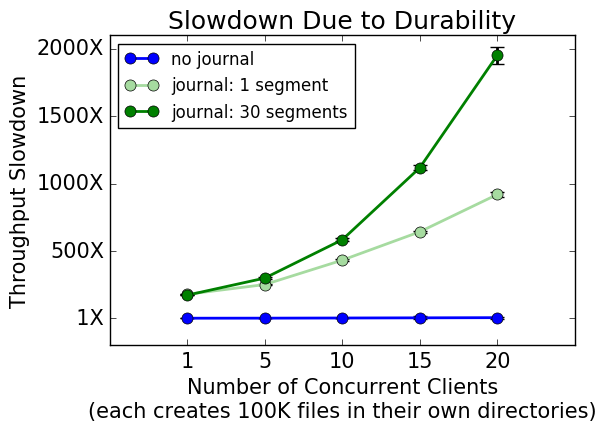

In [4]:
clients = [1, 5, 10, 15, 20]
columns = ['no journal', 'journal: 1 segment', 'journal: 30 segments']
mean = pd.DataFrame(columns=columns)
stds = pd.DataFrame(columns=columns)
for i in clients:
    j0 = parse_mdtest(glob.glob("../results-multipleruns/results-cloudlab-clients1-procs"+str(i)+"-nolog-run*/*isolated*")) 
    j1 = parse_mdtest(glob.glob("../results-multipleruns/results-cloudlab-clients1-procs"+str(i)+"-log1-run*/*isolated*"))    
    j2 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-log10*/*isolated*"))
    mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2)]
    stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2)]

cols_mds = []
mean['clients'] = clients
baseline = str(int(round(100000/mean[mean['clients'] == 1]['no journal'])))
print "baseline=" + baseline
for col in columns:
    mean[col] = mean[col]/float(mean[mean['clients'] == 1]['no journal'])
    cols_mds.append(col)

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean[cols_mds].plot(ax=ax, yerr=stds[cols_mds],
                    color=['blue', '#a6dba0', 'green'],
                    lw=2, marker='o', ms=8,
                    ecolor='black', capthick=1, capsize=5)

ax.set_title("Slowdown Due to Durability")
ax.set_xlim(-1, 5)
ax.set_xticklabels([""] + clients + [""], rotation=0)
ax.set_ylim(-200, 2100)
ax.set_ylabel("Throughput Slowdown")
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
labels = ['{:3.0f}X'.format(x) for x in ax.get_yticks()]
labels[1] = "  1X"
ax.set_yticklabels(labels)

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, fontsize=12, loc='upper left',numpoints=2)

# draw arrow
#arrw = dict(facecolor='black', headwidth=0.5, width=0.5, shrink=1)
#args = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 12, 'arrowprops': arrw}
#ax.annotate('baseline: ' + baseline + ' creates/sec',
#            xy=(0, 1), xytext=(0.45, 700), **args)

print stds
fig.savefig('../../../paper/graphs/slowdown-journal.png', bbox_inches='tight', dpi=400)
mean

# Total Job Perspective
Shows slowdown of MDS

   no journal  journal: 1 parallel segment  journal: 10 parallel segments
0    0.000000                     0.000000                       0.000000
1    0.014267                     0.033843                       0.076331
2    0.033886                     0.044717                       0.044748
3    0.021116                     0.082048                       0.033095
4    0.041259                     0.034745                       0.052451


,no journal,journal: 1 parallel segment,journal: 10 parallel segments
0,1.000000,0.884393,0.889535
1,3.493209,3.048180,2.564187
2,3.873710,3.543039,2.625556
3,3.869831,3.695058,2.054759
4,3.743794,3.412103,1.569948


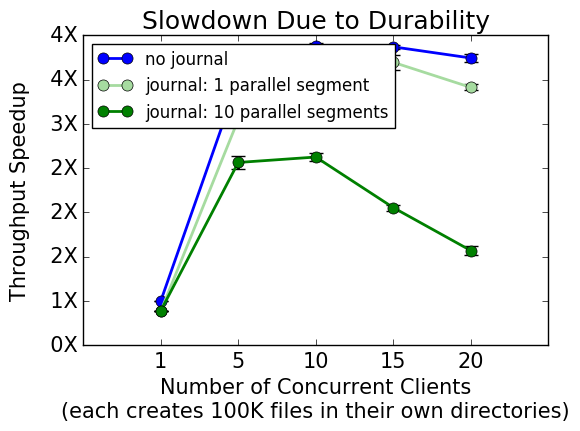

In [5]:
clients = [1, 5, 10, 15, 20]
columns = ['no journal', 'journal: 1 parallel segment', 'journal: 10 parallel segments']
mean = pd.DataFrame(columns=columns)
stds = pd.DataFrame(columns=columns)
norm = np.mean(parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs1-nolog/*isolated*")))
for i in clients:
    j0 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-nolog/*isolated*")) 
    j1 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-log1/*isolated*"))    
    j2 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-log10/*isolated*"))
    j0 = [(i*100000/k)/(100000/norm) for k in j0]
    j1 = [(i*100000/k)/(100000/norm) for k in j1]
    j2 = [(i*100000/k)/(100000/norm) for k in j2]    
    mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2)]
    stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2)]

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean.plot(ax=ax, yerr=stds,
          color=['blue', '#a6dba0', 'green'],
          lw=2, marker='o', ms=8,
          ecolor='black', capthick=1, capsize=5)

ax.set_title("Slowdown Due to Durability")
ax.set_xlim(-1, 5)
ax.set_xticklabels([""] + clients + [""], rotation=0)
#ax.set_ylim(-200, 2100)
ax.set_ylabel("Throughput Speedup")
ax.set_xlabel("Number of Concurrent Clients\n(each creates 100K files in their own directories)")
labels = ['{:3.0f}X'.format(x) for x in ax.get_yticks()]
labels[1] = "  1X"
ax.set_yticklabels(labels)

# remove error bars in legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
ax.legend(handles, labels, fontsize=12, loc='upper left',numpoints=2)

print stds
mean

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,no journal,journal: 1 Seg,journal: 10 Seg,clients
0,640.522876,566.473988,569.767442,1
1,2237.442922,1952.191235,1640.991293,5
2,2481.012658,2269.043760,1681.248928,10
3,2478.642086,2365.626006,1315.789474,15
4,2397.700165,2185.304939,1004.510045,20
5,2425.838647,2054.197270,NaN,25
6,2340.205365,1779.876498,NaN,30
7,NaN,NaN,NaN,35


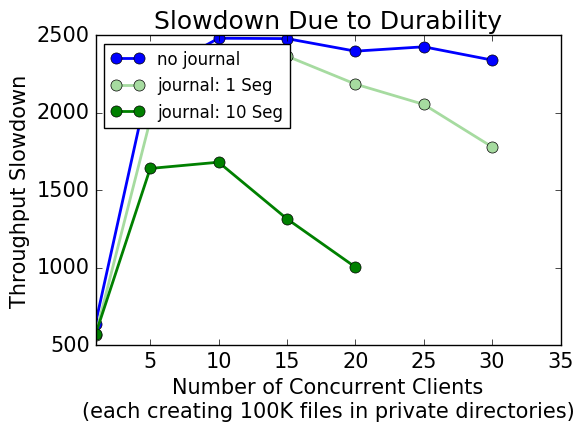

In [6]:
clients = [1, 5, 10, 15, 20, 25, 30, 35]
#clients = [10]
columns = ['no journal', 'journal: 1 Seg', 'journal: 10 Seg']
mean = pd.DataFrame(columns=columns)
stds = pd.DataFrame(columns=columns)
for i in clients:
    j0 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-nolog/*isolated*")) 
    j1 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-log1/*isolated*"))    
    j2 = parse_mdtest(glob.glob("../results-all/results-cloudlab-clients1-procs"+str(i)+"-log10/*isolated*"))
    mean.loc[len(mean)] = [np.mean(j0), np.mean(j1), np.mean(j2)]
    stds.loc[len(stds)] = [np.std(j0), np.std(j1), np.std(j2)]

cols_mds = []
mean['clients'] = clients
baseline = str(int(round(100000/mean[mean['clients'] == 1]['no journal'])))
for col in columns:
    mean[col] = [c*98000 for c in clients]/mean[col]
    #mean[col] = mean[col]/float(mean[mean['clients'] == 1]['no journal'])
    cols_mds.append(col)

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
mean[cols_mds].plot(x=mean['clients'], ax=ax, lw=2, marker='o', ms=8, color=['blue', '#a6dba0', 'green'])
#ax.set_xlim(-1, 32)
#ax.set_ylim(-100, 2000)
#ax.set_yscale('log')
ax.set_ylabel("Throughput Slowdown")
ax.set_xlabel("Number of Concurrent Clients\n(each creating 100K files in private directories)")
#ax.set_yticklabels(['{:3.1f}K'.format(x/1000) for x in ax.get_yticks()])
ax.legend(fontsize=12, loc='upper left')
ax.set_title("Slowdown Due to Durability")
#fig.savefig('../../../paper/graphs/slowdown-journal.png', bbox_inches='tight', dpi=400)

mean

results-cloudlab-clients1-procs32-log-sweep
results-cloudlab-clients1-procs16-log-sweep
results-cloudlab-clients1-procs8-log-sweep
results-cloudlab-clients1-procs4-log-sweep
results-cloudlab-clients1-procs2-log-sweep


(0, 1000)

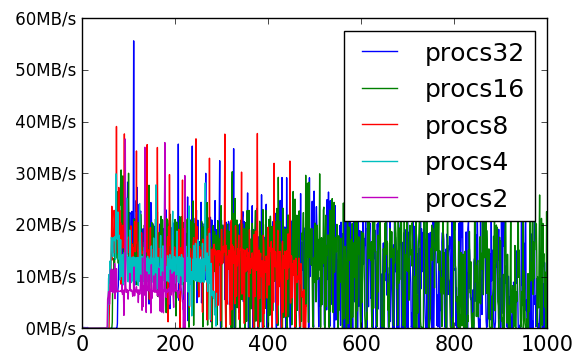

In [7]:
fig, ax = plt.subplots(1, 1)
def network(ax, dirname):
    df = read_timeseries('kbout-eth0', 'kbout_eth0', dirname)
    for i in ['1', '2', '3']:
        df = pd.merge(df, read_timeseries('kbout-eth'+i, 'kbout_eth'+i, dirname), on='Time (sec)')
        
    run = os.path.basename(dirname).split('-')[3]
    df[run] = df['kbout_eth0'] + df['kbout_eth1'] + df['kbout_eth2'] + df['kbout_eth3']
    df.plot(ax=ax, y=[run], label='test')
    print os.path.basename(dirname)
    ax.set_yticklabels(['{:3.0f}MB/s'.format(y/1000) for y in ax.get_yticks()], fontsize=12)

network(ax, '../results-cloudlab-clients1-procs32-log-sweep')    
network(ax, '../results-cloudlab-clients1-procs16-log-sweep')    
network(ax, '../results-cloudlab-clients1-procs8-log-sweep')
network(ax, '../results-cloudlab-clients1-procs4-log-sweep')
network(ax, '../results-cloudlab-clients1-procs2-log-sweep')
ax.set_xlim(0, 1000)